In [1]:
import torch
from torch.utils.data import DataLoader
import numpy as np

In [2]:
base_dir = r"C:\Users\ajinf\Documents\DS 5220\Projects\SML-Project\MRNet-v1.0\train"
file_id = "0000"  

axial_path = f"{base_dir}/axial/{file_id}.npy"
coronal_path = f"{base_dir}/coronal/{file_id}.npy"
sagittal_path = f"{base_dir}/sagittal/{file_id}.npy"

axial_scan = np.load(axial_path)
coronal_scan = np.load(coronal_path)
sagittal_scan = np.load(sagittal_path)

In [5]:
axial_scan.shape, coronal_scan.shape, sagittal_scan.shape

((44, 256, 256), (36, 256, 256), (36, 256, 256))

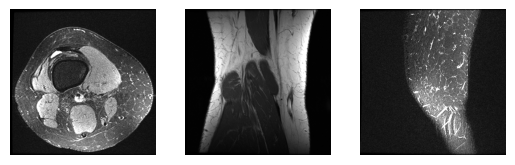

In [7]:
from matplotlib import pyplot as plt
# First slice 
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
for i, j in zip([ax1, ax2, ax3], [axial_scan, coronal_scan, sagittal_scan]):
    i.imshow(j[0], cmap='gray')
    i.axis(False)

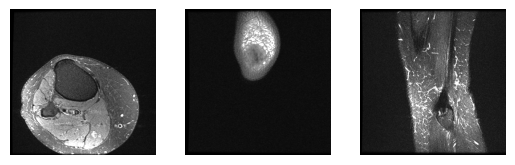

In [8]:
from matplotlib import pyplot as plt
# Last slice
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
for i, j in zip([ax1, ax2, ax3], [axial_scan, coronal_scan, sagittal_scan]):
    i.imshow(j[len(j) - 1], cmap='gray')
    i.axis(False)

In [9]:
import numpy as np

def calculate_entropy(image_slice):
    histogram, _ = np.histogram(image_slice, bins=256, range=(0, 255), density=True)
    histogram = histogram + 1e-6 
    return -np.sum(histogram * np.log2(histogram))

best_slice_index_axial = np.argmax([calculate_entropy(slice) for slice in axial_scan])
best_slice_index_coronal = np.argmax([calculate_entropy(slice) for slice in coronal_scan])
best_slice_index_sagittal = np.argmax([calculate_entropy(slice) for slice in sagittal_scan])

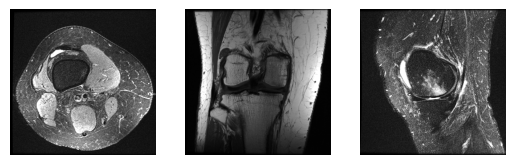

In [13]:
# Choosing the Best Slice using Entropy(Enhances the image and helps in choosing the best slice)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
for i, j, z in zip([ax1, ax2, ax3], [axial_scan, coronal_scan, sagittal_scan], [best_slice_index_axial, best_slice_index_coronal, best_slice_index_sagittal]):
    i.imshow(j[z], cmap='gray')
    i.axis(False)

In [15]:
# Normalizing
axial_scan_normalize = axial_scan / 255.0
coronal_scan_normalize = coronal_scan / 255.0
sagittal_scan_normalize = sagittal_scan / 255.0

In [17]:
# Resizing
import torchvision.transforms as transforms

resize_transform = transforms.Resize((224, 224))

axial_scan_tensor = torch.tensor(axial_scan_normalize, dtype=torch.float32)  
coronal_scan_tensor = torch.tensor(coronal_scan_normalize, dtype=torch.float32)
sagittal_scan_tensor = torch.tensor(sagittal_scan_normalize, dtype=torch.float32)

axial = torch.stack([resize_transform(i.unsqueeze(0)).squeeze(0) for i in axial_scan_tensor])
coronal = torch.stack([resize_transform(i.unsqueeze(0)).squeeze(0) for i in coronal_scan_tensor])
sagittal = torch.stack([resize_transform(i.unsqueeze(0)).squeeze(0) for i in sagittal_scan_tensor])

In [19]:
import numpy as np

def calculate_entropy(image_slice):
    histogram, _ = np.histogram(image_slice, bins=256, range=(0, 255), density=True)
    histogram = histogram + 1e-6 
    return -np.sum(histogram * np.log2(histogram))

best_slice_index_axial = np.argmax([calculate_entropy(slice) for slice in axial])
best_slice_index_coronal = np.argmax([calculate_entropy(slice) for slice in coronal])
best_slice_index_sagittal = np.argmax([calculate_entropy(slice) for slice in sagittal])

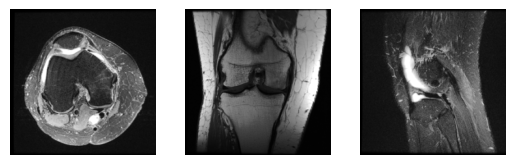

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
for i, j, z in zip([ax1, ax2, ax3], [axial, coronal, sagittal], [best_slice_index_axial, best_slice_index_coronal, best_slice_index_sagittal]):
    i.imshow(j[z], cmap='gray')
    i.axis(False)

Inspect data dimensions, file formats, and storage structure.

In [24]:
# Augmentation
from torchvision.transforms import ToPILImage

to_pil = ToPILImage()
pil_image = to_pil(axial[best_slice_index_axial])

In [28]:
from torchvision import transforms

augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Flip horizontally
    transforms.RandomRotation(degrees=15),   # Rotate within ±15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Adjust brightness and contrast
    transforms.ToTensor()  # Convert to PyTorch tensor
])

augmented_slice = augmentation(pil_image)

# The augmented slice is now a PyTorch tensor
print(augmented_slice.shape)  # Output: torch.Size([1, H, W])

torch.Size([1, 224, 224])


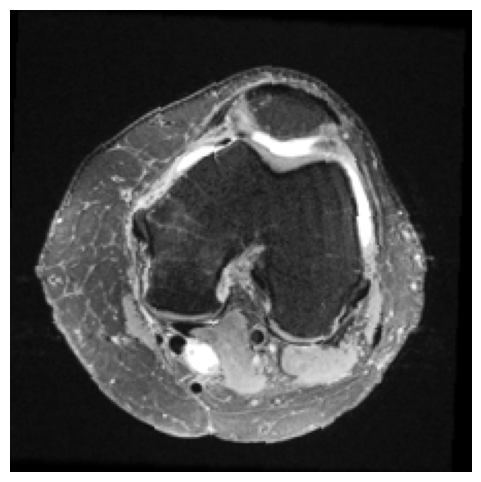

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.imshow(augmented_slice.squeeze(0), cmap='gray')  # Squeeze to remove channel dimension
plt.axis('off')
plt.show()

In [32]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [116]:
# Import necessary libraries for file operations, numerical computations, image processing, and deep learning.
import os  # Used for interacting with the file system (e.g., navigating directories, working with paths).
import numpy as np  # Fundamental library for numerical operations, especially working with arrays.
from PIL import Image  # Python Imaging Library, used for image manipulation and conversion.
import torch  # PyTorch library for tensor operations and building deep learning models.
from torch.utils.data import Dataset, DataLoader, Subset  # Utilities for creating datasets, loaders, and working with subsets.
from torchvision import transforms  # Common image transformations for data preprocessing in PyTorch.
import pandas as pd  # Data manipulation library, used here for handling CSV files.

# Function to pad or truncate data to a fixed target length.
def pad_or_truncate(data, target_length):
    """
    Ensures that the data (e.g., a stack of image slices) has exactly the `target_length`.
    If the data is longer than `target_length`, it truncates it.
    If shorter, it pads with zeros.
    """
    if len(data) >= target_length:  # If data has more or equal slices than target length.
        return data[:target_length]  # Truncate the data to the first `target_length` slices.
    else:
        # Compute the necessary padding to make the data reach `target_length`.
        padding = np.zeros((target_length - len(data), *data.shape[1:]), dtype=data.dtype)  
        return np.concatenate((data, padding), axis=0)  # Concatenate original data with padding.

# Define a custom dataset class to handle MRI scan data for PyTorch.
class MRIDataset(Dataset):
    """
    Custom dataset for loading MRI scan data stored in .npy files and associated labels.
    The dataset can handle multi-label classification for abnormalities, ACL, and meniscus issues.
    """
    def __init__(self, root_dir, transform=None, target_length=20, label_dicts=None):
        """
        Initializes the dataset by scanning the root directory, processing .npy files, 
        and associating them with their labels.

        Args:
        - root_dir (str): Root directory containing MRI scan data folders.
        - transform (callable): Image transformations to apply to each slice.
        - target_length (int): Maximum number of slices to use per file.
        - label_dicts (dict): Dictionary mapping file IDs to labels for different conditions.
        """
        self.root_dir = root_dir  # Root directory where MRI scan files are stored.
        self.transform = transform  # Transformations for image preprocessing.
        self.target_length = target_length  # Target number of slices to use.
        self.data_paths = []  # Stores paths to .npy data files.
        self.labels = []  # Stores corresponding labels for each file.
        self.slice_counts = []  # Number of slices for each .npy file.
        self.label_dicts = label_dicts  # Label mapping for multi-label classification.

        # Scan through directories for different orientations (axial, coronal, sagittal).
        for orientation in os.listdir(root_dir):  # Loop through folders in the root directory.
            orientation_path = os.path.join(root_dir, orientation)
            if os.path.isdir(orientation_path):  # Only process directories (orientation folders).
                # Iterate over all .npy files in the current orientation folder.
                for file_name in os.listdir(orientation_path):
                    if file_name.endswith('.npy'):  # Only consider .npy files.
                        file_path = os.path.join(orientation_path, file_name)  # Get full path.
                        try:
                            # Load the .npy file to check if it contains valid data.
                            np_data = np.load(file_path)
                            if len(np_data) == 0:  # Skip empty files.
                                print(f"Skipping empty file: {file_name}")
                                continue
                            # Calculate the number of slices to use (truncate if necessary).
                            num_slices = min(len(np_data), target_length)
                            self.data_paths.append(file_path)  # Store the file path.
                            self.slice_counts.append(num_slices)  # Store the slice count.

                            # Extract the file ID (without extension) for labeling.
                            file_name_no_ext = os.path.splitext(file_name)[0]
                            # Retrieve labels from the label dictionaries.
                            abnormal_label = label_dicts.get('abnormal', {}).get(int(file_name_no_ext), 0)
                            acl_label = label_dicts.get('acl', {}).get(int(file_name_no_ext), 0)
                            meniscus_label = label_dicts.get('meniscus', {}).get(int(file_name_no_ext), 0)
                            # Append the labels for this file.
                            self.labels.append([abnormal_label, acl_label, meniscus_label])
                        except Exception as e:
                            print(f"Error loading file {file_name}: {e}")  # Handle loading errors.

        # Calculate total slices across all files (useful for indexing).
        self.total_slices = sum(self.slice_counts)
        # Debug information for dataset initialization.
        print(f"Dataset initialized with {len(self.data_paths)} files, total slices: {self.total_slices}.")
        print(f"Data paths: {self.data_paths[:5]}")  # Print first 5 file paths for debugging.
        print(f"Slice counts: {self.slice_counts[:5]}")  # Print first 5 slice counts for debugging.
        print(f"Labels: {self.labels[:5]}")  # Print first 5 labels for debugging.

    def __len__(self):
        """
        Returns the total number of slices across all files in the dataset.
        Required for PyTorch Dataset compatibility.
        """
        return self.total_slices

    def __getitem__(self, idx):
        """
        Fetches a specific slice and its label based on a global index.

        Args:
        - idx (int): Global slice index across the dataset.

        Returns:
        - transformed_slice (Tensor): Transformed image slice.
        - label (Tensor): Corresponding label as a tensor.
        """
        # Determine which file and slice this index corresponds to.
        file_idx, slice_idx = self._find_file_and_slice(idx)
        file_path = self.data_paths[file_idx]  # Get file path for the corresponding file.
        label = self.labels[file_idx]  # Get the label for this file.

        # Load the .npy file, pad/truncate it, and extract the specific slice.
        np_data = np.load(file_path)
        np_data = pad_or_truncate(np_data, self.target_length)
        slice_ = np_data[slice_idx]  # Extract the slice at the specified index.
        # Apply image transformations to the slice.
        transformed_slice = self.transform(Image.fromarray(slice_))

        # Return the transformed slice and label as tensors.
        return transformed_slice, torch.tensor(label, dtype=torch.float32)

    def _find_file_and_slice(self, idx):
        """
        Maps a global slice index to a specific file and slice index within that file.

        Args:
        - idx (int): Global slice index.

        Returns:
        - file_idx (int): Index of the file containing the slice.
        - slice_idx (int): Index of the slice within the file.
        """
        running_total = 0  # Running total of slices processed so far.
        for file_idx, num_slices in enumerate(self.slice_counts):
            if running_total <= idx < running_total + num_slices:
                # Find the specific slice within the current file.
                slice_idx = idx - running_total
                return file_idx, slice_idx
            running_total += num_slices  # Increment running total by slices in this file.
        raise IndexError("Index out of range")  # Handle invalid indices.

# Define a series of image transformations for preprocessing.
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image to 224x224 pixels.
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3 channels (for compatibility with models).
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally.
    transforms.RandomRotation(10),  # Rotate the image randomly by ±10 degrees.
    transforms.RandomAffine(degrees=5, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # Random affine transformations.
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust color properties randomly.
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),  # Apply random perspective distortion.
    transforms.RandomVerticalFlip(),  # Randomly flip the image vertically.
    transforms.ToTensor(),  # Convert the image to a tensor.
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize pixel values.
])

# Load the labels
main_dir = r"C:\Users\ajinf\Documents\DS 5220\Projects\SML-Project\MRNet-v1.0"
train_abnormal = pd.read_csv(os.path.join(main_dir, "train-abnormal.csv"), header=None, index_col=0).squeeze("columns").to_dict()
train_acl = pd.read_csv(os.path.join(main_dir, "train-acl.csv"), header=None, index_col=0).squeeze("columns").to_dict()
train_meniscus = pd.read_csv(os.path.join(main_dir, "train-meniscus.csv"), header=None, index_col=0).squeeze("columns").to_dict()

valid_abnormal = pd.read_csv(os.path.join(main_dir, "valid-abnormal.csv"), header=None, index_col=0).squeeze("columns").to_dict()
valid_acl = pd.read_csv(os.path.join(main_dir, "valid-acl.csv"), header=None, index_col=0).squeeze("columns").to_dict()
valid_meniscus = pd.read_csv(os.path.join(main_dir, "valid-meniscus.csv"), header=None, index_col=0).squeeze("columns").to_dict()

label_dicts = {
    "abnormal": train_abnormal,
    "acl": train_acl,
    "meniscus": train_meniscus
}

valid_label_dicts = {
    "abnormal": valid_abnormal,
    "acl": valid_acl,
    "meniscus": valid_meniscus
}

# Initialize datasets and dataloaders

train_dataset = MRIDataset(root_dir=os.path.join(main_dir, "train"), transform=transform, target_length=25, label_dicts=label_dicts)
val_dataset = MRIDataset(root_dir=os.path.join(main_dir, "valid"), transform=transform, target_length=25, label_dicts=valid_label_dicts)

train_subset = Subset(train_dataset, range(5000))
val_subset = Subset(val_dataset, range(3000))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Debug: Inspect batch shapes
for images, labels in val_loader:
    print(f"Images shape: {images.shape}, Labels shape: {labels.shape}")
    break

Dataset initialized with 3390 files, total slices: 81647.
Data paths: ['C:\\Users\\ajinf\\Documents\\DS 5220\\Projects\\SML-Project\\MRNet-v1.0\\train\\axial\\0000.npy', 'C:\\Users\\ajinf\\Documents\\DS 5220\\Projects\\SML-Project\\MRNet-v1.0\\train\\axial\\0001.npy', 'C:\\Users\\ajinf\\Documents\\DS 5220\\Projects\\SML-Project\\MRNet-v1.0\\train\\axial\\0002.npy', 'C:\\Users\\ajinf\\Documents\\DS 5220\\Projects\\SML-Project\\MRNet-v1.0\\train\\axial\\0003.npy', 'C:\\Users\\ajinf\\Documents\\DS 5220\\Projects\\SML-Project\\MRNet-v1.0\\train\\axial\\0004.npy']
Slice counts: [25, 25, 25, 25, 25]
Labels: [[1, 0, 0], [1, 1, 1], [1, 0, 0], [1, 0, 1], [1, 0, 0]]
Dataset initialized with 360 files, total slices: 8704.
Data paths: ['C:\\Users\\ajinf\\Documents\\DS 5220\\Projects\\SML-Project\\MRNet-v1.0\\valid\\axial\\1130.npy', 'C:\\Users\\ajinf\\Documents\\DS 5220\\Projects\\SML-Project\\MRNet-v1.0\\valid\\axial\\1131.npy', 'C:\\Users\\ajinf\\Documents\\DS 5220\\Projects\\SML-Project\\MRNet-

In [117]:
# Learning rate and number of epochs
lr = 0.001  # Learning rate: controls how much to adjust weights during backpropagation. A lower value prevents overshooting the optimal weights.
epochs = 10  # Number of epochs: how many times the model will go through the entire training dataset.

# Importing necessary modules from PyTorch
import torch.nn as nn  # Neural network components (e.g., layers and activation functions)
import torchvision.models as models  # Pretrained models from the torchvision library

# Loading the EfficientNet-B0 model from torchvision
model = models.efficientnet_b0(pretrained=True)  # EfficientNet-B0 is a lightweight, high-performance convolutional neural network.
# The 'pretrained=True' flag loads a model pre-trained on the ImageNet dataset, which helps in transfer learning.

### ALGORITHM: TRANSFER LEARNING ###
# Transfer learning involves taking a model pre-trained on a large dataset and fine-tuning it for a specific task.
# Pre-trained models provide a good starting point by leveraging features learned on the ImageNet dataset, reducing the need for large datasets or extensive training from scratch.

# Unfreezing all layers of EfficientNet
for param in model.parameters():  # Iterate through all parameters in the model.
    param.requires_grad = True  # Enable gradient computation for all layers.
# By default, pretrained models often freeze their layers to avoid modifying the pre-trained weights.
# Here, we unfreeze all layers because we want to fine-tune the entire model for our task.

### WHY UNFREEZE ALL LAYERS? ###
# Fine-tuning all layers allows the model to adjust low-level features (like edges and textures) in addition to high-level features (like object shapes) for the new dataset.
# This is useful when the target dataset is sufficiently different from ImageNet.

# Replacing the default classifier head with a new one tailored for our problem.
# EfficientNet's original classification head is designed for 1000 ImageNet classes.
model.classifier = nn.Sequential(  # The classifier head is replaced with a custom sequence of layers.
    nn.Dropout(0.9),  # Dropout layer with 90% probability to prevent overfitting.
    # Dropout randomly zeroes out neurons during training, forcing the network to learn robust features.
    nn.Linear(model.classifier[1].in_features, 3)  # Fully connected layer mapping to 3 output classes.
)
# Explanation:
# - `model.classifier[1].in_features`: Retrieves the input size of the original final fully connected layer.
# - `nn.Linear`: Defines a new fully connected layer with the output size set to the number of target classes (3 in this case).
# - `nn.Sequential`: Combines multiple layers (dropout + linear layer) into a single module.

### WHY MODIFY THE CLASSIFIER? ###
# The original EfficientNet is trained on ImageNet with 1000 classes. For tasks like MRI scan classification, we only have 3 target classes (e.g., abnormality, ACL, meniscus).
# By replacing the final layer, the model outputs predictions specific to the number of classes in our dataset.

C:\Users\ajinf\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ajinf\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### KEY CONSIDERATIONS ###
1. **Dropout rate (0.9)**:
   - A high dropout rate is used here. While it prevents overfitting, it may require more epochs for convergence since fewer neurons participate in each forward pass.
   - This is suitable for tasks with small datasets where overfitting is a concern.

2. **Fully connected layer**:
   - Reduces the output size of the classifier to match the task's number of target classes.
   - Each output node corresponds to the probability of one class (e.g., class 0 = "normal", class 1 = "abnormal").

### TRAINING THIS MODEL ###
1. Forward pass:
   - Input MRI slices will pass through EfficientNet's convolutional layers, extracting hierarchical features.
   - The features are flattened and passed through the custom classifier to produce logits for 3 classes.

2. Backpropagation:
   - Loss is computed (e.g., using cross-entropy loss for multi-class classification).
   - Gradients are calculated for all layers since they are unfrozen.
   - Optimizer (e.g., Adam) updates weights across all layers based on gradients.

3. Fine-tuning:
   - Pretrained weights serve as a starting point, and training refines these weights to adapt them to the MRI dataset.

---

In [119]:
# Importing PyTorch and optimizer modules
import torch  # PyTorch core library for tensor operations and deep learning workflows.
import torch.optim as optim  # Optimizer module for gradient-based updates.

# Calculating and displaying the total number of model parameters
total_params = sum(p.numel() for p in model.parameters())  
# `p.numel()`: Returns the number of elements (parameters) in each tensor of the model.
# `sum(...)`: Aggregates the total number of parameters in the model.

print(f"{total_params:,} total parameters.")  # Nicely formatted output of total parameters in the model.

# Calculating and displaying the number of trainable parameters
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad  
    # `p.requires_grad`: Checks if the parameter is trainable (gradient updates will be applied to these).
)
print(f"{total_trainable_params:,} training parameters.")  
# Displays the number of parameters that will be optimized during training.

### WHY CHECK PARAMETERS? ###
# Knowing the total and trainable parameters provides insight into the model's complexity.
# - Helps monitor computational cost and memory requirements.
# - Useful for debugging (e.g., ensuring parameters in desired layers are trainable).

# Setting up the optimizer for training the model
optimizer = optim.Adam([  
    # Using the Adam optimizer: combines the advantages of both RMSProp and momentum, making it suitable for most tasks.
    {'params': model.features.parameters(), 'lr': 1e-5},  
    # `model.features.parameters()`: Parameters of the feature extraction layers (convolutional layers).
    # A smaller learning rate (1e-5) is used here because these layers are pretrained and only need fine-tuning.
    {'params': model.classifier.parameters(), 'lr': 1e-3},  
    # `model.classifier.parameters()`: Parameters of the custom classification head.
    # A higher learning rate (1e-3) is used here since these layers are newly initialized and require more significant updates.
])

# Defining the loss function for the classification task
criterion = nn.BCEWithLogitsLoss()  
# Binary Cross Entropy with Logits Loss is used for binary classification tasks.
# Combines a Sigmoid activation and binary cross-entropy loss in a single, numerically stable computation.

4,011,391 total parameters.
4,011,391 training parameters.


### REASONING BEHIND LEARNING RATE SEPARATION ###
- **Feature extraction layers** (pretrained):
  - Already trained on ImageNet and contain useful general features (e.g., edges, textures).
  - A small learning rate ensures these weights are fine-tuned minimally, avoiding overfitting or "forgetting" pre-trained knowledge.
- **Classifier layers** (custom head):
  - Newly initialized weights are not optimized yet.
  - A higher learning rate allows faster adaptation to the target dataset.
      
### WHY BCE WITH LOGITS LOSS? ###
- This loss is particularly suitable for multi-label binary classification, where each output class is independent of others.
- Logits (raw scores before applying activation functions) are directly fed into the loss, which avoids numerical instabilities during training.
- It calculates the difference between predicted probabilities (after applying Sigmoid) and actual labels, penalizing incorrect predictions.

### ALGORITHM SUMMARY ###
1. **Forward Pass**:
   - The input data passes through `model.features` for feature extraction.
   - These extracted features are then passed through `model.classifier` to generate logits for each class.

2. **Loss Calculation**:
   - The logits are processed by the `BCEWithLogitsLoss` function, which applies a Sigmoid function and computes binary cross-entropy loss.

3. **Backward Pass**:
   - Gradients are computed for both feature extraction layers and classifier layers based on the loss.
   - Gradients for pretrained layers are smaller due to the lower learning rate, while classifier layers have larger updates.

4. **Optimizer Step**:
   - The optimizer updates model weights using gradients and specified learning rates.

---

### CODE PURPOSE AND APPLICATION ###
- This code is designed for binary or multi-label classification tasks.
- The use of separate learning rates ensures efficient fine-tuning of pretrained layers while allowing faster convergence of custom layers.
- The Adam optimizer provides adaptive learning rate adjustments, making it robust for varying gradient magnitudes.


In [121]:
from tqdm import tqdm  # tqdm is used for creating progress bars during training for better visibility.

def train(model, trainloader, optimizer, criterion):
    """
    Function to train a deep learning model for one epoch.

    Args:
        model: The neural network to train.
        trainloader: DataLoader containing the training data.
        optimizer: Optimizer used to update model parameters.
        criterion: Loss function to measure prediction error.

    Returns:
        epoch_loss: Average training loss for the epoch.
        epoch_acc: Training accuracy (%) for the epoch.
    """
    model.train()  # Set the model to training mode (important for layers like Dropout and BatchNorm).
    print('Training')  # Notify the start of training.

    # Initialize running loss and accuracy counters for the epoch.
    train_running_loss = 0.0  # Accumulates the total loss over all batches.
    train_running_correct = 0  # Counts the number of correct predictions.
    counter = 0  # Tracks the number of batches processed.

    # Iterate through the training DataLoader, with tqdm for the progress bar.
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1  # Increment the batch counter.

        # Unpack the batch data.
        image, labels = data  # `image` contains the input images, `labels` contains their corresponding ground truth.
        image, labels = image, labels  # Assign to ensure they are accessible within the scope (may include additional operations like sending to GPU).

        # Zero out the gradients before backpropagation (accumulates by default in PyTorch).
        optimizer.zero_grad()  

        # Forward pass: Compute the output of the model given the input data.
        outputs = model(image)  
        # `outputs` contains the raw logits (unnormalized predictions) for each class.

        # Compute the loss between the predictions and ground truth.
        loss = criterion(outputs, labels)  
        train_running_loss += loss.item()  
        # `.item()` extracts the scalar loss value for aggregation (loss tensors remain in the computational graph).

        # Compute the predictions using a threshold of 0.5.
        preds = torch.sigmoid(outputs) > 0.5  
        # Applies the Sigmoid activation function to logits to convert them to probabilities.
        # Predictions greater than 0.5 are treated as positive.

        # Count correct predictions by comparing predicted labels with ground truth.
        train_running_correct += (preds == labels).sum().item()  
        # `(preds == labels)` creates a Boolean tensor of correct predictions, which is summed to count correct examples.

        # Backpropagation: Compute gradients of the loss w.r.t. model parameters.
        loss.backward()  

        # Update the model parameters using the optimizer.
        optimizer.step()  

    # Calculate the average loss for the epoch.
    epoch_loss = train_running_loss / counter  
    # Divide the accumulated loss by the number of batches.

    # Calculate accuracy as a percentage.
    epoch_acc = 100. * (train_running_correct / (len(trainloader.dataset) * labels.size(1)))  
    # `train_running_correct` counts correct predictions.
    # `len(trainloader.dataset) * labels.size(1)` is the total number of predictions (total samples * labels per sample).
    # Multiplied by 100 to convert to a percentage.

    # Return the average loss and accuracy for the epoch.
    return epoch_loss, epoch_acc

In [122]:
def validate(model, testloader, criterion):
    """
    Function to validate a deep learning model after training.

    Args:
        model: The trained neural network to evaluate.
        testloader: DataLoader containing the validation/test data.
        criterion: Loss function to measure prediction error.

    Returns:
        epoch_loss: Average validation loss for the epoch.
        epoch_acc: Validation accuracy (%) for the epoch.
    """
    model.eval()  # Set the model to evaluation mode (disables layers like Dropout and BatchNorm updates).
    print('Validation')  # Notify the start of validation.

    # Initialize running loss and accuracy counters for the epoch.
    valid_running_loss = 0.0  # Accumulates the total loss over all batches.
    valid_running_correct = 0  # Counts the number of correct predictions.
    counter = 0  # Tracks the number of batches processed.

    # Disable gradient calculations to save memory and computation during evaluation.
    with torch.no_grad():  
        # Iterate through the validation DataLoader, with tqdm for the progress bar.
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1  # Increment the batch counter.

            # Unpack the batch data.
            image, labels = data  # `image` contains the input images, `labels` contains their corresponding ground truth.
            image, labels = image, labels  # Assign for accessibility and possible pre-processing.

            # Forward pass: Compute the output of the model given the input data.
            outputs = model(image)  
            # `outputs` contains the raw logits (unnormalized predictions) for each class.

            # Compute the loss between the predictions and ground truth.
            loss = criterion(outputs, labels)  
            valid_running_loss += loss.item()  
            # `.item()` extracts the scalar loss value for aggregation.

            # Compute the predictions using a threshold of 0.5.
            preds = torch.sigmoid(outputs) > 0.5  
            # Applies the Sigmoid activation function to logits to convert them to probabilities.
            # Predictions greater than 0.5 are treated as positive.

            # Count correct predictions by comparing predicted labels with ground truth.
            valid_running_correct += (preds == labels).sum().item()  
            # `(preds == labels)` creates a Boolean tensor of correct predictions, which is summed to count correct examples.

    # Calculate the average loss for the epoch.
    epoch_loss = valid_running_loss / counter  
    # Divide the accumulated loss by the number of batches.

    # Calculate accuracy as a percentage.
    epoch_acc = 100. * (valid_running_correct / (len(testloader.dataset) * labels.size(1)))  
    # `valid_running_correct` counts correct predictions.
    # `len(testloader.dataset) * labels.size(1)` is the total number of predictions (total samples * labels per sample).
    # Multiplied by 100 to convert to a percentage.

    # Return the average loss and accuracy for the epoch.
    return epoch_loss, epoch_acc

In [123]:
from PIL import Image  # For image processing tasks (not used directly here).
import time  # To introduce pauses during the loop for demonstration purposes.

# Lists to store loss and accuracy for each epoch during training and validation.
train_loss, valid_loss = [], []  # To store training and validation losses.
train_acc, valid_acc = [], []  # To store training and validation accuracies.

# Start the training and validation process for the specified number of epochs.
for epoch in range(epochs):  # Loop over the number of epochs.
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")  # Informative print to indicate the current epoch.
    
    # **Training Phase**:
    # Call the `train` function, passing the model, training DataLoader, optimizer, and loss function.
    # It returns the average training loss and accuracy for the current epoch.
    train_epoch_loss, train_epoch_acc = train(model, train_loader, 
                                              optimizer, criterion)
    
    # **Validation Phase**:
    # Call the `validate` function, passing the model, validation DataLoader, and loss function.
    # It returns the average validation loss and accuracy for the current epoch.
    valid_epoch_loss, valid_epoch_acc = validate(model, val_loader,  
                                                 criterion)
    
    # Append the epoch metrics to the corresponding lists for tracking.
    train_loss.append(train_epoch_loss)  # Store the training loss.
    valid_loss.append(valid_epoch_loss)  # Store the validation loss.
    train_acc.append(train_epoch_acc)  # Store the training accuracy.
    valid_acc.append(valid_epoch_acc)  # Store the validation accuracy.
    
    # Print the loss and accuracy for the current epoch.
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)  # Separator for clarity in logs.
    
    # Optional pause for better readability during training logs.
    time.sleep(5)  # Introduces a 5-second pause between epochs.

[INFO]: Epoch 1 of 10
Training


100%|██████████| 2552/2552 [1:02:32<00:00,  1.47s/it]


Validation


100%|██████████| 272/272 [02:06<00:00,  2.14it/s]


Training loss: 0.539, training acc: 74.799
Validation loss: 0.639, validation acc: 65.598
--------------------------------------------------
[INFO]: Epoch 2 of 10
Training


100%|██████████| 2552/2552 [1:09:07<00:00,  1.63s/it]


Validation


100%|██████████| 272/272 [02:11<00:00,  2.07it/s]


Training loss: 0.509, training acc: 76.071
Validation loss: 0.611, validation acc: 67.421
--------------------------------------------------
[INFO]: Epoch 3 of 10
Training


100%|██████████| 2552/2552 [1:11:52<00:00,  1.69s/it]


Validation


100%|██████████| 272/272 [02:17<00:00,  1.98it/s]


Training loss: 0.491, training acc: 76.724
Validation loss: 0.595, validation acc: 68.202
--------------------------------------------------
[INFO]: Epoch 4 of 10
Training


100%|██████████| 2552/2552 [1:00:45<00:00,  1.43s/it]


Validation


100%|██████████| 272/272 [02:05<00:00,  2.17it/s]


Training loss: 0.479, training acc: 77.197
Validation loss: 0.579, validation acc: 69.378
--------------------------------------------------
[INFO]: Epoch 5 of 10
Training


100%|██████████| 2552/2552 [59:42<00:00,  1.40s/it] 


Validation


100%|██████████| 272/272 [02:05<00:00,  2.16it/s]


Training loss: 0.472, training acc: 77.476
Validation loss: 0.568, validation acc: 70.286
--------------------------------------------------
[INFO]: Epoch 6 of 10
Training


100%|██████████| 2552/2552 [1:00:05<00:00,  1.41s/it]


Validation


100%|██████████| 272/272 [02:07<00:00,  2.13it/s]


Training loss: 0.465, training acc: 77.715
Validation loss: 0.560, validation acc: 70.435
--------------------------------------------------
[INFO]: Epoch 7 of 10
Training


100%|██████████| 2552/2552 [59:46<00:00,  1.41s/it] 


Validation


100%|██████████| 272/272 [02:05<00:00,  2.16it/s]


Training loss: 0.460, training acc: 77.907
Validation loss: 0.557, validation acc: 71.067
--------------------------------------------------
[INFO]: Epoch 8 of 10
Training


100%|██████████| 2552/2552 [1:00:47<00:00,  1.43s/it]


Validation


100%|██████████| 272/272 [02:09<00:00,  2.10it/s]


Training loss: 0.455, training acc: 78.155
Validation loss: 0.563, validation acc: 71.170
--------------------------------------------------
[INFO]: Epoch 9 of 10
Training


100%|██████████| 2552/2552 [1:12:03<00:00,  1.69s/it]


Validation


100%|██████████| 272/272 [02:12<00:00,  2.05it/s]


Training loss: 0.451, training acc: 78.351
Validation loss: 0.552, validation acc: 71.825
--------------------------------------------------
[INFO]: Epoch 10 of 10
Training


100%|██████████| 2552/2552 [1:01:31<00:00,  1.45s/it]


Validation


100%|██████████| 272/272 [02:07<00:00,  2.13it/s]


Training loss: 0.446, training acc: 78.561
Validation loss: 0.557, validation acc: 71.913
--------------------------------------------------


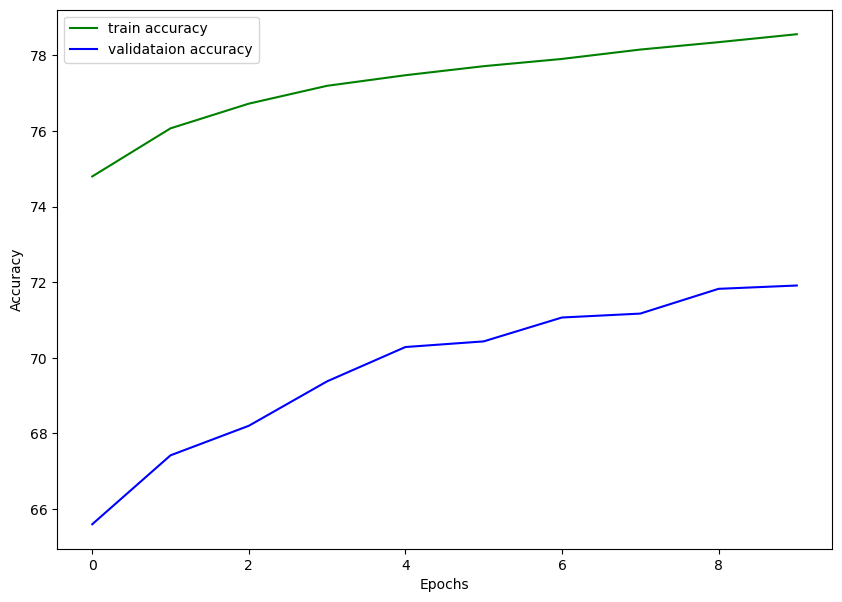

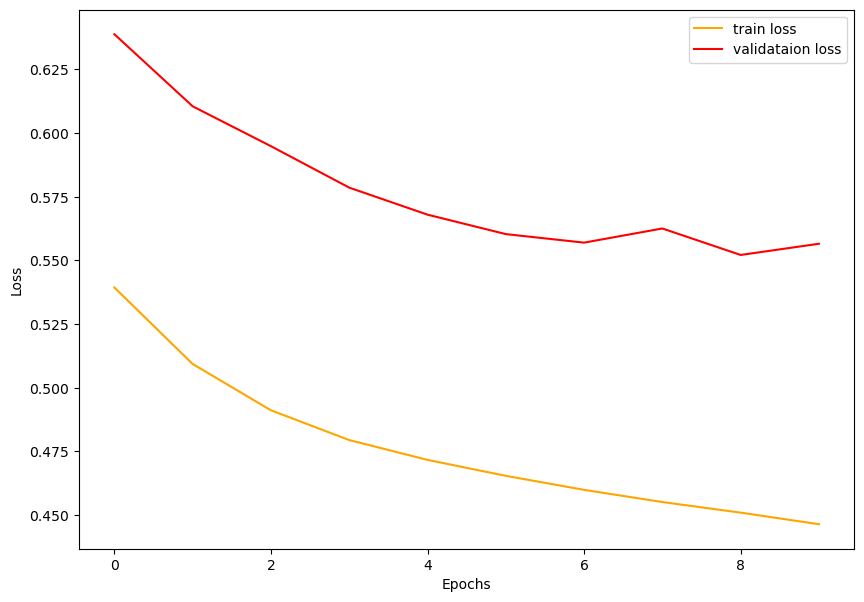

In [132]:
plt.figure(figsize=(10, 7))
plt.plot(
    train_acc, color='green', linestyle='-', 
    label='train accuracy'
)
plt.plot(
    valid_acc, color='blue', linestyle='-', 
    label='validataion accuracy'
)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# loss plots
plt.figure(figsize=(10, 7))
plt.plot(
    train_loss, color='orange', linestyle='-', 
    label='train loss'
)
plt.plot(
    valid_loss, color='red', linestyle='-', 
    label='validataion loss'
)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()